<a href="https://colab.research.google.com/github/Niloofar-SecML/CNN/blob/main/Triplet_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model

In [ ]:
# dataset downloading
lfw_people = fetch_lfw_people(min_faces_per_person=10, resize=0.5)

In [ ]:
print("Image shape:", lfw_people.images.shape)  # (n_samples, height, width)
print("Target names:", lfw_people.target_names)

Image shape: (4324, 62, 47)
Target names: ['Abdullah Gul' 'Adrien Brody' 'Alejandro Toledo' 'Alvaro Uribe'
 'Amelie Mauresmo' 'Andre Agassi' 'Andy Roddick' 'Angelina Jolie'
 'Ann Veneman' 'Anna Kournikova' 'Ari Fleischer' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Atal Bihari Vajpayee' 'Bill Clinton'
 'Bill Gates' 'Bill McBride' 'Bill Simon' 'Britney Spears' 'Carlos Menem'
 'Carlos Moya' 'Catherine Zeta-Jones' 'Charles Moose' 'Colin Powell'
 'Condoleezza Rice' 'David Beckham' 'David Nalbandian' 'Dick Cheney'
 'Dominique de Villepin' 'Donald Rumsfeld' 'Edmund Stoiber'
 'Eduardo Duhalde' 'Fidel Castro' 'George HW Bush' 'George Robertson'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Gonzalo Sanchez de Lozada' 'Gordon Brown' 'Gray Davis' 'Guillermo Coria'
 'Halle Berry' 'Hamid Karzai' 'Hans Blix' 'Harrison Ford'
 'Hillary Clinton' 'Howard Dean' 'Hu Jintao' 'Hugo Chavez' 'Ian Thorpe'
 'Igor Ivanov' 'Jack Straw' 'Jackie Chan' 'Jacques Chirac' 'Jacques Rogge'
 'James Blake' 

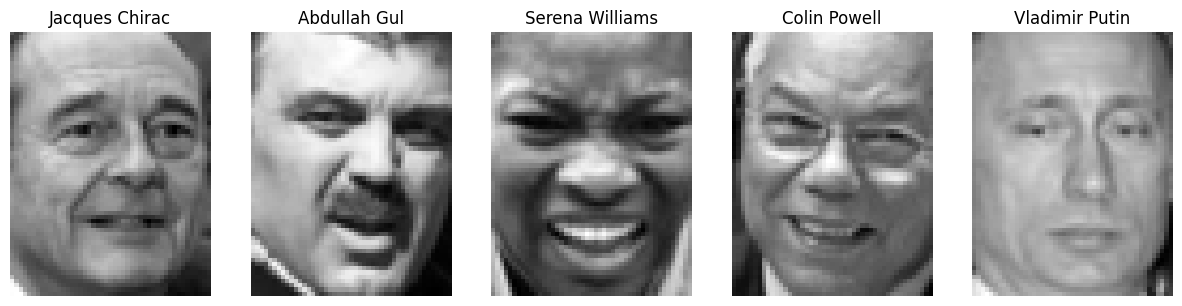

In [ ]:
#show some image
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(lfw_people.images[i], cmap='gray')
    axes[i].set_title(lfw_people.target_names[lfw_people.target[i]])
    axes[i].axis('off')
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()  #select file

Saving lfw.tgz to lfw.tgz


In [ ]:
!tar -xvzf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [ ]:
import os

lfw_folder = "lfw"
lfw_contents = os.listdir(lfw_folder)[:10]
print(lfw_contents)

['Mike_Miller', 'Francis_Ricciardone', 'Bart_Hendricks', 'Miguel_Rosseto', 'Brooke_Gordon', 'Lisa_Marie_Presley', 'Jessica_Brungo', 'Kostya_Tszyu', 'Eugene_Teslovic', 'Hans-Christian_Schmid']


In [ ]:
#triplet loss
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split

def get_people_with_two_images(data_path="lfw"):
    people = {}
    for person in os.listdir(data_path):
        images = glob(os.path.join(data_path, person, "*.jpg"))
        if len(images) >= 2:
            people[person] = images
    return people

people_dict = get_people_with_two_images()

print(f"Found {len(people_dict)} people with at least two images.")

Found 1680 people with at least two images.


In [ ]:
# Triplet (anchor, positive, negative)
def create_triplets(people_dict, num_triplets=1000):
    triplets = []

    people = list(people_dict.keys())

    for _ in range(num_triplets):
        # Anchor و Positive one person
        person = random.choice(people)
        imgs = random.sample(people_dict[person], 2)
        anchor, positive = imgs[0], imgs[1]

        # Negative other person
        negative_person = random.choice([p for p in people if p != person])
        negative = random.choice(people_dict[negative_person])

        triplets.append((anchor, positive, negative))

    return triplets

triplets = create_triplets(people_dict)
print(f"Generated {len(triplets)} triplets")

Generated 1000 triplets


In [ ]:
#transfer to vector
def build_embedding_model(input_shape=(96, 96, 3), embedding_dim=128):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, (10,10), activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (7,7), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (4,4), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (4,4), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='sigmoid')(x)
    outputs = layers.Dense(embedding_dim)(x)

    return Model(inputs, outputs, name="embedding_model")

In [ ]:
def triplet_loss(_, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred  # چون یک لیست از سه تنسوره

    # فاصله بین anchor و positive
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)

    # فاصله بین anchor و negative
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

    # محاسبه basic triplet loss
    basic_loss = pos_dist - neg_dist + alpha

    # جمع کردن کل loss
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss


In [ ]:
triplet_model.compile(optimizer='adam', loss=lambda y_true, y_pred: y_pred)

In [ ]:
#create triplet network
def build_triplet_model(embedding_model):
    # inputs
    input_anchor = Input(shape=(96, 96, 3), name='anchor_input')
    input_positive = Input(shape=(96, 96, 3), name='positive_input')
    input_negative = Input(shape=(96, 96, 3), name='negative_input')

    # embedding
    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    # embeddings
    merged_output = Lambda(lambda x: x, name='triplet_output')([embedding_anchor, embedding_positive, embedding_negative])

    # loss function
    model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

    return model

In [ ]:
embedding_model = build_embedding_model()
triplet_model = build_triplet_model(embedding_model)
triplet_model.compile(optimizer='adam', loss=triplet_loss)

In [ ]:
import cv2
import numpy as np

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (96, 96))
    img = img.astype('float32') / 255.0
    return img

In [ ]:
anchor_paths = [triplet[0] for triplet in triplets]
positive_paths = [triplet[1] for triplet in triplets]
negative_paths = [triplet[2] for triplet in triplets]

In [ ]:
import cv2
import numpy as np

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (96, 96))
    img = img.astype('float32') / 255.0
    return img

In [ ]:
anchor_images = np.array([load_and_preprocess_image(path) for path in anchor_paths])
positive_images = np.array([load_and_preprocess_image(path) for path in positive_paths])
negative_images = np.array([load_and_preprocess_image(path) for path in negative_paths])

In [ ]:
anchor_paths = [triplet[0] for triplet in triplets]
positive_paths = [triplet[1] for triplet in triplets]
negative_paths = [triplet[2] for triplet in triplets]

In [ ]:
import cv2
import numpy as np

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (96, 96))
    img = img.astype('float32') / 255.0
    return img

In [ ]:
anchor_images = np.array([load_and_preprocess_image(path) for path in anchor_paths])
positive_images = np.array([load_and_preprocess_image(path) for path in positive_paths])
negative_images = np.array([load_and_preprocess_image(path) for path in negative_paths])

In [ ]:
y_dummy = np.zeros((anchor_images.shape[0],))

In [ ]:
embedding_model = build_embedding_model()
triplet_model = build_triplet_model(embedding_model)
triplet_model.compile(optimizer='adam', loss=triplet_loss)

In [ ]:
embedding_model = build_embedding_model()

In [ ]:
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model

def build_triplet_model(embedding_model):
    input_anchor = Input(shape=(96, 96, 3), name='anchor_input')
    input_positive = Input(shape=(96, 96, 3), name='positive_input')
    input_negative = Input(shape=(96, 96, 3), name='negative_input')

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    # اضافه کردن output_shape به Lambda
    merged_output = Lambda(
        lambda x: triplet_loss(None, x),
        output_shape=(1,)
    )([embedding_anchor, embedding_positive, embedding_negative])

    model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)
    return model

In [ ]:
triplet_model = build_triplet_model(embedding_model)
triplet_model.compile(optimizer='adam', loss=lambda y_true, y_pred: y_pred)

In [ ]:
triplet_model.fit(
    [anchor_images, positive_images, negative_images],
    np.zeros((anchor_images.shape[0],)),
    batch_size=32,
    epochs=20
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 429s 13s/step - loss: 0.2167
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 435s 14s/step - loss: 0.1538
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 441s 14s/step - loss: 0.1728
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 437s 13s/step - loss: 0.1670
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 432s 14s/step - loss: 0.1478
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 430s 13s/step - loss: 0.1558
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 444s 13s/step - loss: 0.1357
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 425s 13s/step - loss: 0.1175
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 443s 13s/step - loss: 0.1204
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 440s 13s/step - loss: 0.1157
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 438s 13s/step - loss: 0.1112
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 446s 13s/step - loss: 0.1146
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 434s 13s/step - loss: 0.1192
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 442s 13s/step - loss: 0.1158
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 433s 13s/step - lo

In [ ]:
path = 'lfw/Carly_Fiorina/Carly_Fiorina_0001.jpg'

In [ ]:
img = load_and_preprocess_image(path)
img = np.expand_dims(img, axis=0)
new_embedding = embedding_model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


In [ ]:
database = {
    "Carly_Fiorina": embedding_model.predict(np.expand_dims(load_and_preprocess_image('lfw/Carly_Fiorina/Carly_Fiorina_0002.jpg'), axis=0)),
    "George_W_Bush": embedding_model.predict(np.expand_dims(load_and_preprocess_image('lfw/George_W_Bush/George_W_Bush_0001.jpg'), axis=0)),
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [ ]:
for name, emb in database.items():
    dist = np.linalg.norm(new_embedding - emb)
    print(f"{name}: distance = {dist}")

Carly_Fiorina: distance = 0.7469853162765503
George_W_Bush: distance = 0.8260741233825684


Using Siame model for verificationn

In [ ]:
def build_siamese_model(input_shape=(96, 96, 3)):
    input_1 = Input(shape=input_shape, name="input_1")
    input_2 = Input(shape=input_shape, name="input_2")

    base_model = build_embedding_model(input_shape)  # embedding_model

    embedding_1 = base_model(input_1)
    embedding_2 = base_model(input_2)

    # (L1 Distance)
    l1_distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding_1, embedding_2])

    # Dense
    output = Dense(1, activation='sigmoid')(l1_distance)

    model = Model(inputs=[input_1, input_2], outputs=output)
    return model

In [ ]:
!ls

lfw  lfw.tgz  sample_data


In [ ]:
import os
import random
import numpy as np
from glob import glob
from collections import defaultdict

def create_siamese_pairs(base_path='lfw', image_size=(96, 96), max_pairs=1000):
    people = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    people_with_2_imgs = [p for p in people if len(os.listdir(os.path.join(base_path, p))) >= 2]

    positive_pairs = []
    negative_pairs = []

    # ✅ Positive pairs (هم‌کلاس)
    for person in people_with_2_imgs:
        imgs = glob(os.path.join(base_path, person, '*.jpg'))
        selected = random.sample(imgs, 2)
        positive_pairs.append((selected[0], selected[1], 1))

    # ✅ Negative pairs (غیرهم‌کلاس)
    while len(negative_pairs) < len(positive_pairs):
        p1, p2 = random.sample(people_with_2_imgs, 2)
        i1 = random.choice(glob(os.path.join(base_path, p1, '*.jpg')))
        i2 = random.choice(glob(os.path.join(base_path, p2, '*.jpg')))
        negative_pairs.append((i1, i2, 0))

    all_pairs = positive_pairs + negative_pairs
    random.shuffle(all_pairs)
    return all_pairs

In [ ]:
import cv2

def preprocess_image(path, target_size=(96, 96)):
    img = cv2.imread(path)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img

In [ ]:
pairs = create_siamese_pairs()
X1 = []
X2 = []
y = []

for img1_path, img2_path, label in pairs:
    X1.append(preprocess_image(img1_path))
    X2.append(preprocess_image(img2_path))
    y.append(label)

X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)

In [ ]:
from tensorflow.keras import layers, Model, Input

def create_base_network(input_shape=(96, 96, 3)):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(64, (10,10), activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (7,7), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (4,4), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (4,4), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='sigmoid')(x)

    return Model(inputs, x)

In [ ]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

base_network = create_base_network()

input_a = Input(shape=(96, 96, 3))
input_b = Input(shape=(96, 96, 3))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])
siamese_model = Model([input_a, input_b], distance)

In [ ]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

In [ ]:
siamese_model.compile(loss=contrastive_loss, optimizer='adam')
siamese_model.fit([X1, X2], y, batch_size=32, epochs=10)